## Методические указания по выполнению лабораторной работы №3

**Тема: Обнаружение объектов с использованием Faster R-CNN**

**Цель работы:** Ознакомиться с архитектурой Faster R-CNN и принципами двухэтапного обнаружения объектов.

**Задачи:**
- Изучить теоретические основы двухэтапного обнаружения объектов: роль RPN и классификационного этапа в Faster R-CNN.
- Загрузить предобученную модель Faster R-CNN.
- Ознакомиться с форматом аннотаций для обучения в задаче детекции.
- Визуализировать предсказания, проанализировать ошибки модели и провести исследование по поиску баланса FN/FP.

### 1. Теоретическая часть

В данной лабораторной работе мы познакомимся с задачей детекции на примере архитектуры [Faster R-CNN](https://arxiv.org/pdf/1506.01497), обученной на наборе данных [COCO](https://cocodataset.org/#home), а также с новым форматом данных для обучения нейро-сетевых моделей детекции. Для оценки модели воспользуемся набором данных [Pascal VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/).

**Перед тем, как приступать к выполнению практической части, ознакомьтесь с первоисточниками используемых компонентов, а также документацией по [ссылке](https://pytorch.org/vision/master/models/faster_rcnn.html), включающей подробности работы с моделью и новым форматом данных, сэмплы кода.**

#### 1.1 Архитектура Faster R-CNN

Существует два основных подхода к обнаружению объектов:
Двухстадийные модели – более точные, но медленные.
Одностадийные модели – быстрые, но менее точные.

Faster R-CNN — это двухэтапная модель детекции объектов. В отличие от ResNeXt, Faster R-CNN не просто классифицирует изображение, а находит на нём несколько объектов, предсказывает bounding boxes и присваивает метки классам. Она состоит из следующих компонентов:

1. Backbone (ResNet/VGG/MobileNet) – извлекает признаки из изображения.
2. Region Proposal Network (RPN) – предлагает области, где могут находиться объекты.
3. ROI Pooling + Fully Connected Layers – классифицирует объекты и уточняет bounding boxes.
4. Non-Maximum Suppression (NMS) – убирает дублирующиеся предсказания.


В предыдущих лабораторных работах мы познакомились с классификацией изображений, где модель предсказывает единственный класс для всего изображения. Однако во многих задачах компьютерного зрения классификация недостаточна. Например, когда на одном изображении присутствуют несколько объектов разных классов необходимо не только определить, что изображено, но и где это находится.

Faster R-CNN –  модель, которая также решает задачу обнаружения объектов, добавляя к классификации локализацию. 

#### 1.2 Формат данных для задачи детекции

Faster R-CNN требует разметки изображений, помимо классов включающей в себя и координаты bounding box по оси x, y.
Ознакомьтесь с форматом набора данных Pascal VOC, скачайте аннотации набора данных и изучите структуру **.xml** файлов в папке Annotations по [ссылке](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtestnoimgs_06-Nov-2007.tar).

#### 1.3 Оценка качества

Помимо известных вам инструментов оценить качество работы детектора могут помочь:

Confidence Score - значение, указывающее на уверенность модели в том, что на данном месте изображения находится объект. Модель предсказывает этот параметр для каждого предсказанного bounding box. Чем выше confidence score, тем более уверена модель в своём предсказании.

Фильтрация предсказаний - модель может предсказать много объектов, но не все из них будут точными. Чтобы уменьшить количество ложных срабатываний (False Positives), применяется фильтр предсказаний, используя confidence threshold. Если confidence score меньше заданного порога - предсказание отбрасывается.


### 2. Практическая часть

#### 2.1 Подготовка окружения

Установите зависимости и библиотеки:

In [1]:
# импорт пакетов
import torch 
from torch import nn, optim, tensor
import torchvision
from torchvision import models, datasets, transforms
from torchvision.models.detection import FasterRCNN
import numpy as np
import matplotlib.pyplot as plt
# from torchvision.models.detection.rpn import AnchorGenerator

#### 2.2 Подготовка модели

Загрузите предобученную модель, определите устройство, переведите модель в режим инференса:

In [2]:
# импорт модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Используемое устройство:", device)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Переводим модель в режим оценки (не для обучения)
model.eval()

Используемое устройство: cpu


c:\Users\ttemuchin4\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ttemuchin4\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

#### 2.3 Загрузка и предобработка изображений


Затем импортируйте датасет из соответствующих пакетов PyTorch и определите метод трансформации данных для подачи в модель. Он понадобится позже для преобразования изображений при прямом проходе через модель чтобы получить предсказания:

In [ ]:
# метод трансформации # загрузка датасета
transform = transforms.Compose([
    transforms.ToTensor(),
])
# изображение автоматически преобразовывается в тензор при загрузке.
dataset = torchvision.datasets.VOCDetection(root="./data", download=True, year="2007", transform=transform)

#### 2.4 Объявление методов для работы с данными

Далее необходимо создать методы препроцессинга: метод чтения файла аннотации для возврата numpy-объекта содержащего bounding boxes, и метод отрисовки истиных и прогнозных bounding boxes на изображении для визуализации полученных результатов.

In [4]:
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET

def parse_voc_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes = []

    for obj in root.findall("object"):
        bbox = obj.find("bndbox")
        xmin, ymin, xmax, ymax = (int(bbox.find("xmin").text), int(bbox.find("ymin").text),
                                  int(bbox.find("xmax").text), int(bbox.find("ymax").text))
        boxes.append([xmin, ymin, xmax, ymax])
    return np.array(boxes)

def draw_predictions(image, boxes, labels, scores, color="blue"):
    draw = ImageDraw.Draw(image)
    for box, label, score in zip(boxes, labels, scores):
        xmin, ymin, xmax, ymax = map(int, box)
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)
        draw.text((xmin, ymin), f"{label} ({score:.2f})", fill=color)
    return image

#### 2.5 Анализ False Positives / False Negatives

Для измерения того, насколько хорошо bounding box предсказан, применяется параметр IoU (Intersection over Union) между двумя bounding boxes. Чем он выше, тем точнее предсказание. Для его оценки опишем следующий метод, принимающий два np.array-объекта (прогнозные и истинные координаты):

In [5]:
def calculate_iou(pred_box, gt_box):
    x1, y1, x2, y2 = pred_box
    x1g, y1g, x2g, y2g = gt_box
    
    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

#### 2.6 Оценка модели и визуализация результатов

Выполните прямой проход нескольких изображений через модель. Для этого необходимо загрузить изображения и аннотации, применить преобразование изображений в тензор. Затем получите выходы модели:

In [12]:
# выберите N изображений 5 из датасета
# image_filenames = [voc_dataset[i][1]['annotation']['filename'] for i in range(N)]

# {'annotation': 
#  {'folder': 'VOC2007', 'filename': '000017.jpg', 'source':
#  {'database': 'The VOC2007 Database', 'annotation': 'PASCAL VOC2007', 'image': 'flickr', 'flickrid': '228217974'}, 
#   'owner': {'flickrid': 'genewolf', 'name': 'whiskey kitten'}, 
#   'size': {'width': '480', 'height': '364', 'depth': '3'}, 
#   'segmented': '0', 
#   'object': [{'name': 'person', 'pose': 'Left', 'truncated': '0', 'difficult': '0', 
#             'bndbox': {'xmin': '185', 'ymin': '62', 'xmax': '279', 'ymax': '199'}}, 
#             {'name': 'horse', 'pose': 'Left', 'truncated': '0', 'difficult': '0', 
#              'bndbox': {'xmin': '90', 'ymin': '78', 'xmax': '403', 'ymax': '336'}}]}}

def testFRCNN(N, CT, showImg):
# # объявите цикл для проверки
    FP = 0
    FN = 0
    for i in range(N):
        # загрузите изображение и его разметку
        image_tensor, target = dataset[i]
        
        image_filename = target['annotation']['filename']
        xml_path = f"./data/VOCdevkit/VOC2007/Annotations/{image_filename.replace('.jpg', '.xml')}"
        # print(xml_path)
        gt_boxes = parse_voc_annotation(xml_path)

        # примените трансформации
        image_tensor = image_tensor.unsqueeze(0).to(device)

        # выполните прямой проход
        with torch.no_grad():
            outputs = model(image_tensor)

        # извлекаем bounding boxes, метки и confidence scores из полученных выходов модели
        pred_boxes = outputs[0]['boxes'].cpu().numpy()
        pred_labels = outputs[0]['labels'].cpu().numpy()
        pred_scores = outputs[0]['scores'].cpu().numpy()

        # установите порог confidence_threshold в эмпирическом значении 0.5
        confidence_threshold = CT

        # примените фильтр выходных значений на основе заданного порога
        mask = pred_scores >= confidence_threshold
        # print(mask)
        pred_boxes = pred_boxes[mask]
        pred_labels = pred_labels[mask]
        pred_scores = pred_scores[mask]

        # CONVERT тензорa обратно в PIL.Image для визуализации
        image_pil = transforms.ToPILImage()(image_tensor.squeeze(0).cpu())

        # отрисуйте bounding boxes на изображении с предсказаниями
        image_with_predictions = draw_predictions(image_pil.copy(), pred_boxes, pred_labels, pred_scores, color="blue")

        # отрисуйте bounding boxes с реальной разметкой
        image_with_gt = draw_predictions(image_pil.copy(), gt_boxes, ["GT"] * len(gt_boxes), [1.0] * len(gt_boxes), color="green")

        # Визуализация результатов
        if showImg:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Predictions")
            plt.imshow(image_with_predictions)
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.title("Ground Truth")
            plt.imshow(image_with_gt)
            plt.axis("off")

            plt.show()

        # вычислите IoU для выбранных изображений
        iou_scores = []
        for pred_box in pred_boxes:
            iou_max = 0
            for gt_box in gt_boxes:
                iou = calculate_iou(pred_box, gt_box)
                if iou > iou_max:
                    iou_max = iou
            iou_scores.append(iou_max)

        # подсчитайте количество False Positive и False Negative для выбранных изображений
        true_positives = sum(iou > 0.5 for iou in iou_scores)
        false_positives = abs(len(pred_boxes) - true_positives)
        false_negatives = abs(len(gt_boxes) - true_positives)
        FP += false_positives
        FN += false_negatives

        if showImg:
            print(f"Изображение {i + 1}:")
            print(f"  True Positives (TP): {true_positives}")
            print(f"  False Positives (FP): {false_positives}")
            print(f"  False Negatives (FN): {false_negatives}")
            print(f"  Средний IoU: {np.mean(iou_scores):.2f}")

    return FP, FN

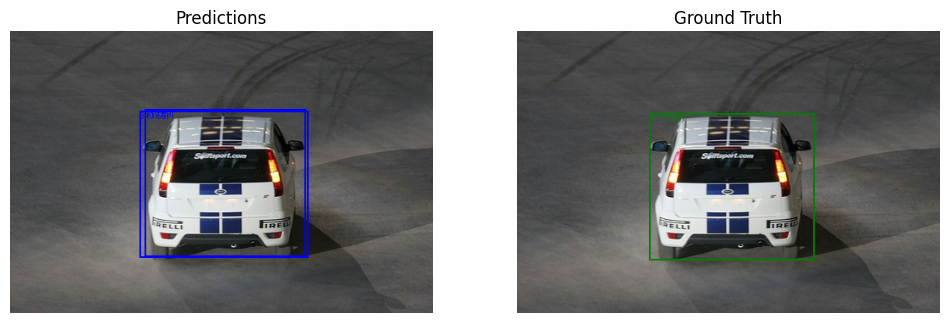

Изображение 1:
  True Positives (TP): 2
  False Positives (FP): 0
  False Negatives (FN): 1
  Средний IoU: 0.94


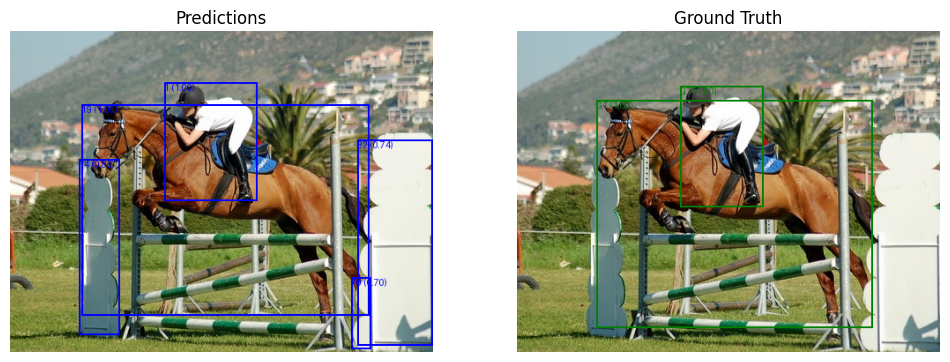

Изображение 2:
  True Positives (TP): 2
  False Positives (FP): 3
  False Negatives (FN): 0
  Средний IoU: 0.37


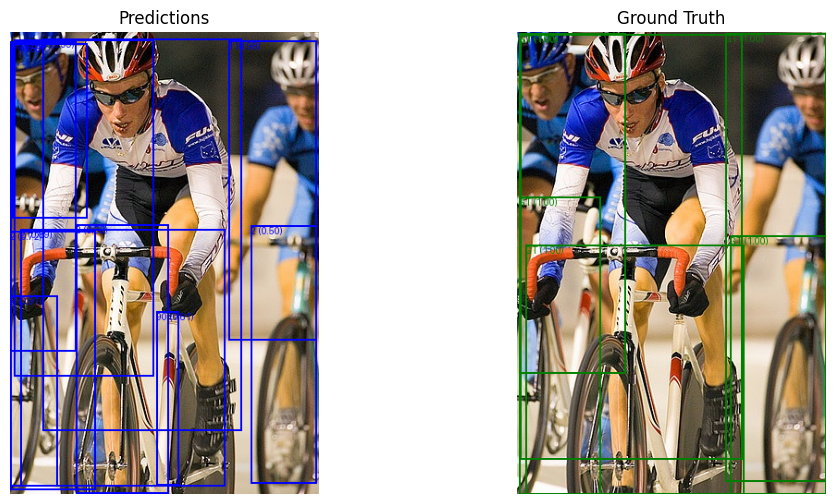

Изображение 3:
  True Positives (TP): 7
  False Positives (FP): 4
  False Negatives (FN): 1
  Средний IoU: 0.56


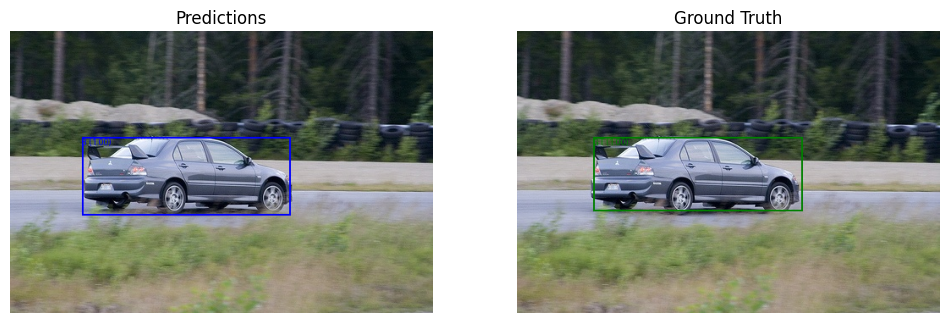

Изображение 4:
  True Positives (TP): 1
  False Positives (FP): 0
  False Negatives (FN): 0
  Средний IoU: 0.90


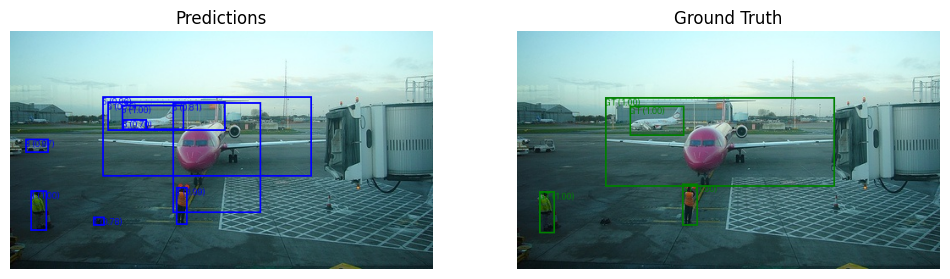

Изображение 5:
  True Positives (TP): 4
  False Positives (FP): 5
  False Negatives (FN): 0
  Средний IoU: 0.43


In [13]:
testFP, testFN = testFRCNN(5, 0.5, True)

#### 2.7 Поиск оптимальной конфигурации 

Проанализируйте полученные результаты с выбранным значением фильтрации предсказаний. Проведите исследование с целью поиска оптимального порога и баланса FN/FP. Обоснуйте полученные результаты:

CONFIDENCE THRESHOLD = 0.1 FP: 128 FN: 11
CONFIDENCE THRESHOLD = 0.2 FP: 69 FN: 6
CONFIDENCE THRESHOLD = 0.3 FP: 50 FN: 5
CONFIDENCE THRESHOLD = 0.4 FP: 35 FN: 3
CONFIDENCE THRESHOLD = 0.5 FP: 32 FN: 3
CONFIDENCE THRESHOLD = 0.6 FP: 28 FN: 1
CONFIDENCE THRESHOLD = 0.7 FP: 25 FN: 1
CONFIDENCE THRESHOLD = 0.8 FP: 17 FN: 5
CONFIDENCE THRESHOLD = 0.9 FP: 10 FN: 8
CONFIDENCE THRESHOLD = 1.0 FP: 0 FN: 26


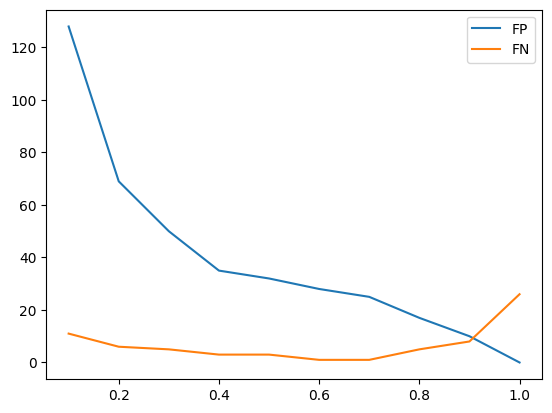

In [17]:
sumFP = []
sumFN = []
confidence_thresholds = [i/10 + 0.1 for i in range(10)]
for threshold in confidence_thresholds:
    fp, fn = testFRCNN(10, threshold, False)
    sumFP.append(fp)
    sumFN.append(fn)
    print("CONFIDENCE THRESHOLD = " + str(round(threshold, 1)), "FP:", fp, "FN:", fn)

plt.plot(confidence_thresholds, sumFP, label="FP")
plt.plot(confidence_thresholds, sumFN, label="FN")
plt.legend()
plt.show()